In [1]:
!wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
!unzip -q dataset1.zip
!rm dataset1.zip
!pip install -q torch_snippets pytorch_model_summary

In [2]:
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
    
    def __len__(self): return len(self.items)
    
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224, 224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224, 224))
        return image, mask
    
    def choose(self): return self[randint(len(self))]
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy() / 255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [5]:
train_ds = SegData('train')
valid_ds = SegData('test')

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True, collate_fn=valid_ds.collate_fn)

In [6]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [7]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [8]:
from torchvision.models import vgg16_bn

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        
        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)
        
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)
        
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)
        
        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)
        
        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)
        
        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)
        
        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)
        
        x = self.conv11(x)
        
        return x

In [9]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [10]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [11]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:15<00:00, 35.2MB/s] 


In [12]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dl)
    for bx, data in enumerate(train_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex + (bx + 1) / N, trn_loss=loss, trn_acc=acc, end='\r')
    
    N = len(valid_dl)
    for bx, data in enumerate(valid_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex + (bx + 1) / N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex + 1)

EPOCH: 1.000  val_loss: 0.824  val_acc: 0.766  trn_acc: 0.725  trn_loss: 1.172  (17.01s - 323.23s remaining)
EPOCH: 2.000  val_loss: 0.671  val_acc: 0.838  trn_acc: 0.808  trn_loss: 0.725  (28.78s - 259.00s remaining)
EPOCH: 3.000  val_loss: 0.730  val_acc: 0.807  trn_acc: 0.837  trn_loss: 0.601  (40.71s - 230.69s remaining)
EPOCH: 4.000  val_loss: 0.568  val_acc: 0.846  trn_acc: 0.848  trn_loss: 0.548  (52.57s - 210.29s remaining)
EPOCH: 5.000  val_loss: 0.536  val_acc: 0.847  trn_acc: 0.866  trn_loss: 0.484  (64.33s - 193.00s remaining)
EPOCH: 6.000  val_loss: 0.461  val_acc: 0.868  trn_acc: 0.876  trn_loss: 0.440  (76.03s - 177.41s remaining)
EPOCH: 7.000  val_loss: 0.512  val_acc: 0.850  trn_acc: 0.881  trn_loss: 0.419  (87.73s - 162.93s remaining)
EPOCH: 8.000  val_loss: 0.434  val_acc: 0.869  trn_acc: 0.884  trn_loss: 0.404  (99.47s - 149.20s remaining)
EPOCH: 9.000  val_loss: 0.417  val_acc: 0.876  trn_acc: 0.894  trn_loss: 0.368  (111.17s - 135.88s remaining)
EPOCH: 10.000  val

100%|██████████| 121/121 [00:00<00:00, 768.45it/s]


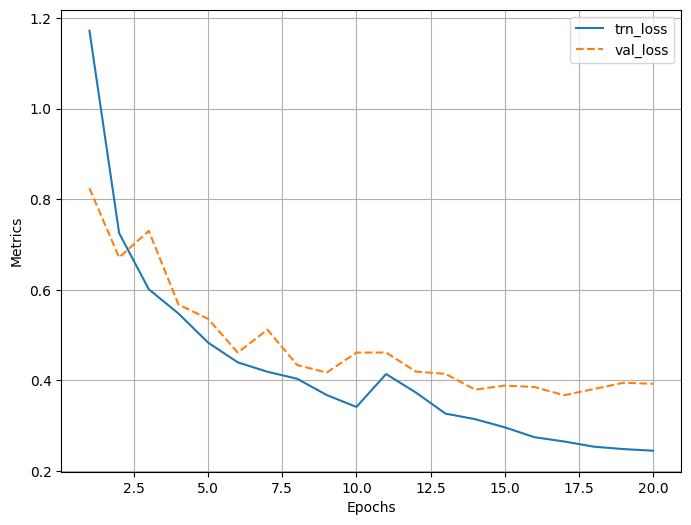

In [13]:
log.plot_epochs(['trn_loss', 'val_loss'])

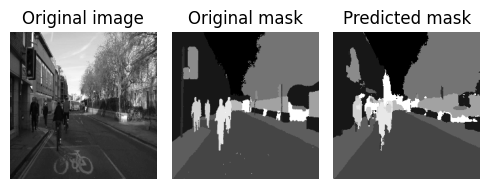

In [15]:
im, mask = next(iter(valid_dl))
_mask = model(im)

_, _mask = torch.max(_mask, dim=1)

subplots([im[0].permute(1, 2, 0).detach().cpu()[:, :, 0], 
          mask.permute(1, 2, 0).detach().cpu()[:, :, 0],
         _mask.permute(1, 2, 0).detach().cpu()[:, :, 0]], nc=3,
         titles=['Original image', 'Original mask', 'Predicted mask'])